# Create a notebook to perform CKRK integration with adaptive step sizes


In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

# Define our derivatives

In [2]:
def dydx(x,y):
    
    #set the derivatives
    
    #our equation is d^2y/dx^2 = -y
    
    #so we can write
    #dydx = z
    #dzdx = -y
    
    #we will set y = y[0]
    #we will set z = y[1]
    
    #declare an array
    y_derivs = np.zeros(2)
    
    #set dydx = z
    y_derivs[0] =    y[1]
    
    #set dzdx = -y
    y_derivs[1] = -1*y[0]
    
    #here we return the array
    return y_derivs

# Define the Cash-Karp Runge-Kutta method

In [3]:
def ckrk_mv_core(dydx,xi,yi,nv,h):
    
    #declare the h? arrays
    k1 = np.zeros(nv)
    k2 = np.zeros(nv)
    k3 = np.zeros(nv)
    k4 = np.zeros(nv)
    k5 = np.zeros(nv)
    k6 = np.zeros(nv)
    
    c = [1/5, 3/10, 3/5, 1, 7/8]
    a2  = [1/5]
    a3  = [3/40, 9/40]
    a4  = [3/10, -9/10, 6/5]
    a5  = [-11/54, 5/2, -70/20, 35/27]
    a6  = [1631/55296, 175/512, 575/13824, 44275/110592, 253/4096]
    bi  = [37/378, 0, 250/621, 125/594, 0, 512/1771]
    bis = [2825/27648, 0, 18575/48384, 13525/55296, 277/14336, 1/4]
    
    #define x at c2 steps
    x_c2 = xi + c[0]*h
    
    #define x at c3 steps
    x_c3 = xi + c[1]*h
    
    #define x at c4 steps
    x_c4 = xi + c[2]*h
    
    #define x at c5 steps
    x_c5 = xi + c[3]*h
    
    #define x at c6 steps
    x_c6 = xi + c[4]*h
    
    #declare a temp y array
    y_temp = np.zeros(nv)
    
    #get k1 values
    y_derivs = dydx(xi,yi)
    k1[:] = h*y_derivs[:]
    
    #get k2 values
    y_temp[:] = yi[:] + a2[0]*k1[:]
    y_derivs[:] = dydx(x_c2, y_temp)
    k2[:] = h*y_derivs[:]
    
    #get k3 values
    y_temp[:] = yi[:] + a3[0]*k1[:] + a3[1]*k2[:]
    y_derivs[:] = dydx(x_c3,y_temp)
    k3[:] = h*y_derivs[:]
    
    #get k4 values
    y_temp[:] = yi[:] + a4[0]*k1[:] + a4[1]*k2[:] + a4[2]*k3[:]
    y_derivs[:] = dydx(x_c4,y_temp)
    k4[:] = h*y_derivs[:]
    
    #get k5 values
    y_temp[:] = yi[:] + a5[0]*k1[:] + a5[1]*k2[:] + a5[2]*k3[:] + a5[3]*k4[:]
    y_derivs[:] = dydx(x_c5,y_temp)
    k5[:] = h*y_derivs[:]
    
    #get k6 values
    y_temp[:] = yi[:] + a6[0]*k1[:] + a6[1]*k2[:] + a6[2]*k3[:] + a6[3]*k4[:]+ a6[4]*k5[:]
    y_derivs[:] = dydx(x_c6,y_temp)
    k6[:] = h*y_derivs[:]
    
    #advance y by a steep h
    yipoi  = yi + bi[0]*k1 +  bi[1]*k2 +  bi[2]*k3 +  bi[3]*k4 +  bi[4]*k5 +  bi[5]*k6 
    yipois = yi + bis[0]*k1 +  bis[1]*k2 +  bis[2]*k3 +  bis[3]*k4 +  bis[4]*k5 +  bis[5]*k6
    yipo = yipoi - yipois
    
    return yipo

# Define an adaptive step size driver for CKRK

In [4]:
def ckrk_mv_ad(dydx,x_i,y_i,nv,h,tol):
    
    #define safety scale
    SAFETY    = 0.9
    H_NEW_FAC = 2.0
    
    #set a maximum number of iterations 
    imax = 10000
    
    #set an iteration variable
    i = 0
    
    #create an error
    Delta = np.full(nv,2*tol)
    
    #remeber the step 
    h_step = h
    
    #adjust step
    while(Delta.max()/tol > 1.0):
        
        #estimate our error by taking one step of size h
        #vs. two steps of size h/2
        y_2 =  ckrk_mv_core(dydx,x_i,y_i,nv,h_step)
        y_1 =  ckrk_mv_core(dydx,x_i,y_i,nv,0.5*h_step)
        y_11 = ckrk_mv_core(dydx,x_i+0.5*h_step,y_1,nv,0.5*h_step)
        
        #compute an error
        Delta = np.fabs(y_2 - y_11)
        
        #if the rror is too large, take a smaller step
        if(Delta.max()/tol >1.0):
            
            #our error is too large, decrease the step
            h_step *= SAFETY * (Delta.max()/tol)**(-0.25)
        
        #check iteration
        if(i>=imax):
            print("Too many iterations in rk4_mv_ad()")
            raise StopIterations("Ending after i = ",i)
        
        #iterate
        i+=1
    
    #next time, try to take a bigger step
    h_new = np.fmin(h_step * (Delta.max()/tol)**(-0.9), h_step*H_NEW_FAC)
    
    #Return the answer, a new step, and the step we actually took
    return y_2, h_new, h_step

# Define a wrapper for CKRK

In [5]:
def ckrk_mv(dfdx,a,b,y_a,tol):
    
    #dfdx is the derivaste wrt x
    #a is the lower bound
    #b is the upper bound
    #y_a are the boundary conditions
    #tol is the tolerance for integrating y
    
    #define our starting step
    xi = a
    yi = y_a.copy()
    
    #an initial step size == make very small
    h = 1.0e-4 * (b-a)
    
    #set a maximun number of iterations 
    imax = 10000
    
    #set an iteration variable 
    i = 0
    
    #set the number of coupled odes to the
    #size of y_a
    nv = len(y_a)
    
    #set the initial conditions
    x = np.full(1,a)
    y = np.full((1,nv),y_a)
    
    #set a flag
    flag = 1
    
    #loop until we reach the right side
    while(flag):
        
        #calculate y_i+1
        yi_new, h_new, h_step = ckrk_mv_ad(dydx,xi,yi,nv,h,tol)
        
        #update the step
        h = h_new
        
        #prevent an overshoot
        if(xi+h_step>b):
            
            #take a smaller step
            h = b-xi
            
            #recalculate y_i+1
            yi_new, h_new, h_step = ckrk_mv_ad(dydx,xi,yi,nv,h,tol)
            
            #break
            flag = 0
            
        #update values
        xi += h_step
        yi[:] = yi_new[:]
            
        #add the step to the arrays
        x = np.append(x,xi)
        y_new = np.zeros((len(x),nv))
        y_new[0:len(x)-1,:] = y
        y_new[-1,:] = yi[:]
        del y
        y = y_new
            
        #prevent too many iterations
        if(i>=imax):
                
            print("Maximum iterations reached.")
            raise StopIteration('Iteration number = ',i)
                
        #iterate
        i += 1
            
        #output some information
        s = "i = %3d\tx = %9.8f\th = %9.8f\tb=%9.8f" % (i,xi, h_step, b)
        print(s)
            
        #break if new xi is == b
        if(xi==b):
            flag = 0
        
    #return the answer
    return x,y

# Perform the integration

In [6]:
a = 0.0
b = 2.0 * np.pi

y_0 = np.zeros(2)
y_0[0] = 0.0
y_0[1] = 1.0
nv = 10

tolerance = 1.0e-6

#perform the integration
x,y = ckrk_mv(dydx,a,b,y_0,tolerance)

i =   1	x = 0.00062832	h = 0.00062832	b=6.28318531
i =   2	x = 0.00188496	h = 0.00125664	b=6.28318531
i =   3	x = 0.00439823	h = 0.00251327	b=6.28318531
i =   4	x = 0.00942478	h = 0.00502655	b=6.28318531
i =   5	x = 0.01947787	h = 0.01005310	b=6.28318531
i =   6	x = 0.03958407	h = 0.02010619	b=6.28318531
i =   7	x = 0.07979645	h = 0.04021239	b=6.28318531
i =   8	x = 0.16022123	h = 0.08042477	b=6.28318531
i =   9	x = 0.32107077	h = 0.16084954	b=6.28318531
i =  10	x = 0.64276986	h = 0.32169909	b=6.28318531
i =  11	x = 1.28616803	h = 0.64339818	b=6.28318531
i =  12	x = 2.57296438	h = 1.28679635	b=6.28318531
i =  13	x = 5.14655709	h = 2.57359270	b=6.28318531
i =  14	x = 6.28318531	h = 1.13662822	b=6.28318531


# Plot the results

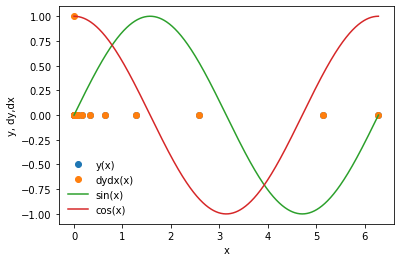

In [15]:
plt.plot(x,y[:,0],'o',label='y(x)')
plt.plot(x,y[:,1],'o',label='dydx(x)')
xx = np.linspace(0,2.0*np.pi,1000)
plt.plot(xx,np.sin(xx),label='sin(x)')
plt.plot(xx,np.cos(xx),label='cos(x)')
plt.xlabel('x')
plt.ylabel('y, dy,dx')
plt.legend(frameon=False)

# Plot the error
#### Notice that errors will actually exceed our "tolerance".

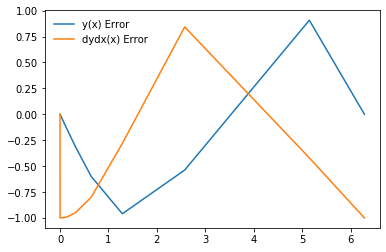

In [8]:
sine = np.sin(x)
cosine = np.cos(x)

y_error = (y[:,0]-sine)
dydx_error = (y[:,1]-cosine)

plt.plot(x, y_error, label="y(x) Error")
plt.plot(x, dydx_error, label="dydx(x) Error")
plt.legend(frameon=False)